## 1 - Preparation ##


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import json
import pickle
import seaborn as sns
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Data Acquisition ##

In [2]:
SOUND_FOLDER_training = "./Audio_Dataset/training_data"
SOUND_FOLDER_testing = "./Audio_Dataset/testing_data"
FEAT_FOLDER = "./Features"
CLASS_FOLDER = "./Audio_Dataset"

# Load Features

path = os.path.join(FEAT_FOLDER+"/feature_training.pkl")
df_feature_training = pd.read_pickle(path)

path = os.path.join(FEAT_FOLDER+"/feature_testing.pkl")
df_feature_testing = pd.read_pickle(path)

# Load Training and Testing Datasets

path = os.path.join(SOUND_FOLDER_training+"/label_training.csv")
df_labels_training = pd.read_csv(path)

path = os.path.join(SOUND_FOLDER_testing+"/label_testing.csv")
df_labels_testing = pd.read_csv(path)

path = os.path.join(CLASS_FOLDER+"/classes.csv")
df_classes = pd.read_csv(path)

# Merge features and label dataframes
feat_df_training = df_feature_training.merge(df_labels_training, how='inner', on=['path','file_name'])
feat_df_testing = df_feature_testing.merge(df_labels_testing, how='inner', on=['path','file_name'])

train_set_x = feat_df_training.drop(["path", 'file_name', 'class'], axis=1).to_numpy().T;
train_label_y = feat_df_training["class"].to_numpy();
train_label_y = train_label_y.reshape((train_label_y.shape[0],1)).T

test_set_x = feat_df_testing.drop(["path", 'file_name', 'class'], axis=1).to_numpy().T;
test_label_y = feat_df_testing["class"].to_numpy();
test_label_y = test_label_y.reshape((test_label_y.shape[0],1)).T

classes = df_classes.drop(['num'], axis=1).to_numpy().reshape((2,))

train_set_y = np.zeros((1,train_set_x.shape[1]), dtype='int')

for i in np.arange(train_label_y.shape[1]):
    if train_label_y[:,i] == 'metal':
        train_set_y[:,i] = 0
    elif train_label_y[:,i] == 'classical':
        train_set_y[:,i] = 1

test_set_y = np.zeros((1,test_set_x.shape[1]), dtype='int')

for i in np.arange(test_label_y.shape[1]):
    if test_label_y[:,i] == 'metal':
        test_set_y[:,i] = 0
    elif test_label_y[:,i] == 'classical':
        test_set_y[:,i] = 1

print(train_set_y.shape)
print(test_set_y)

(1, 160)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]


## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## 4 - Building the parts of our algorithm ## 


In [3]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    z = z.astype('float')
    s = 1/(1 + np.exp(-z))
    
    return s

### 4.1 - Initializing parameters


In [4]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### 4.2 - Forward and Backward propagation

Forward Propagation:
- You get X (feature matrix)
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Back Propagation: 
- Compute the GRADIENT of the Cost Function
    
    Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [5]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_features, 1) where num_features = 22 MFCCs
    b -- bias, a scalar
    X -- data of size (num_features, number of examples)
    Y -- true "label" vector (containing 0 if metal, 1 if classical) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1] # number of audio files

    X = X.astype('float');
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                            # compute activation
    cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum((A-Y))

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### 4.3 - Optimization

- Update the parameters using gradient descent.

In [6]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_features, 1)
    b -- bias, a scalar
    X -- data of shape (num_features, number of examples)
    Y -- true "label" vector (containing 0 if metal, 1 if classical), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [7]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_features, 1)
    b -- bias, a scalar
    X -- data of size (num_features, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of the audio file to be a classical song
    A = sigmoid(np.dot(w.T,X)+b) 
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## 5 - Merge all functions into a model ##


In [8]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_features, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_features, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(np.shape(X_train)[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "grads": grads,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [9]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.0005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.028698
Cost after iteration 200: 0.017229
Cost after iteration 300: 0.012702
Cost after iteration 400: 0.010193
Cost after iteration 500: 0.008569
Cost after iteration 600: 0.007419
Cost after iteration 700: 0.006558
Cost after iteration 800: 0.005885
Cost after iteration 900: 0.005344
Cost after iteration 1000: 0.004898
Cost after iteration 1100: 0.004525
Cost after iteration 1200: 0.004206
Cost after iteration 1300: 0.003932
Cost after iteration 1400: 0.003692
Cost after iteration 1500: 0.003482
Cost after iteration 1600: 0.003295
Cost after iteration 1700: 0.003128
Cost after iteration 1800: 0.002978
Cost after iteration 1900: 0.002842
train accuracy: 100.0 %
test accuracy: 95.0 %


In [10]:
# Example of an audio file that was wrongly classified.
index = 38

print('Prediction: ' + str(classes[int(d['Y_prediction_test'][0][index])]))
print('Ground truth: ' + test_label_y[0][index])

print(classes)

print(d['Y_prediction_train'].shape)
print(d['Y_prediction_test'].shape)

print(d['Y_prediction_train'])
print(d['Y_prediction_test'])


Prediction: metal
Ground truth: classical
['metal' 'classical']
(1, 160)
(1, 40)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]]


Let's also plot the cost function.

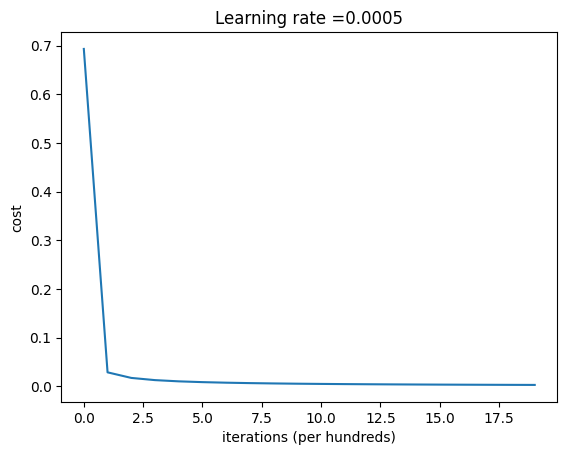

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()